In [1]:
import numpy as np
import warnings
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def predict_stock_direction(ticker, n_days, n_hist_wk, fe = None, n_components = 10, prt = True):
    warnings.filterwarnings('ignore')
    # ================== Data Preparation ====================
    end_date = datetime.today()
    start_date = end_date - timedelta(weeks=n_hist_wk)

    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

    data['price_change'] = data['Close'].pct_change()
    data['volume_change'] = data['Volume'].pct_change()
    data['relative_high'] = (data['High'] - data['Close']) / data['Close']
    data['relative_low'] = (data['Low'] - data['Close']) / data['Close']

    feature_df = pd.DataFrame()

    # Add recent n_days data
    for i in range(n_days, 0, -1):
        feature_df[f'price_change_{i}'] = data['price_change'].shift(i)
        feature_df[f'volume_change_{i}'] = data['volume_change'].shift(i)
        feature_df[f'relative_high_{i}'] = data['relative_high'].shift(i)
        feature_df[f'relative_low_{i}'] = data['relative_low'].shift(i)
    
    # Add other factor
    feature_df['day_in_week'] = data.index.dayofweek
    feature_df['day_in_month'] = data.index.day
    feature_df['month_in_year'] = data.index.month
    feature_df['quarter'] = data.index.quarter
    
    # Build Feature df
    feature_df['price_change'] = data['Close'].pct_change()
    feature_df = feature_df.dropna()
    
    if prt: print('... Data prepared! Data size:', feature_df.shape)

    # =================== Train-test split, feature engineering =========================
    X = feature_df.drop(columns=['price_change'])
    y = feature_df['price_change']

    X_train_ori, X_test_ori, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if prt: print('... Train/Tests splitted! Train size:', X_train_ori.shape)
    
    # Normalize the input data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train_ori)
    X_test_normalized = scaler.transform(X_test_ori)

    # PCA model
    pca = PCA(n_components=n_components)
    
    # Autoencoder model
    input_dim = X_train_normalized.shape[1]
    encoding_dim = n_components
    input_layer = Input(shape=(input_dim,))
    encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
    decoder_layer = Dense(input_dim, activation='linear')(encoder_layer)
    autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    X_train = None
    X_test  = None
    if fe == 'pca':
        X_train = pca.fit_transform(X_train_normalized)
        X_test = pca.transform(X_test_normalized)
        if prt: print('... PCA done! Train size:', X_train.shape)
    elif fe == 'ae':
        autoencoder.fit(X_train_normalized, X_train_normalized,
                    epochs=100,  # You can choose the number of epochs
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test_normalized, X_test_normalized))
        encoder = Model(inputs=input_layer, outputs=encoder_layer)
        X_train = encoder.predict(X_train_normalized)
        X_test = encoder.predict(X_test_normalized)
        if prt: print('... Autoencoder trained! Train size:', X_train.shape)
    else:
        if prt: print('... No dimensionality reduction will be performed. Train size:', X_train.shape)
    
    scoring_metrics = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False)
    }
    
    if prt: print('... Model training started!')
    
    # ==================== Elastic Net Regression =======================
    if prt: print('Model1: Elastic Net Regression ...')
    elastic_net = ElasticNet(random_state=42)
    param_grid5 = {
        'alpha': np.logspace(-4, 4, 9),
        'l1_ratio': np.linspace(0, 1, 11)
    }
    grid_search_en = GridSearchCV(
        elastic_net, param_grid5, scoring='neg_mean_squared_error', cv=5, n_jobs=24)
    grid_search_en.fit(X_train, y_train)
    #print(f'... Best Elastic Net error on training set: {grid_search_en.best_score_:.4f}')
    best_en = grid_search_en.best_estimator_
    y_pred = best_en.predict(X_test)
    #print(f'... Best Elastic Net error on test set: {mean_squared_error(y_test, y_pred):.4f}')

    # ==================== Polynomial Regression with Ridge Regularization =======================
    if prt: print('Model2: Polynomial Regression ...')
    poly_ridge_grid_search = Pipeline([
        ('poly_features', PolynomialFeatures(include_bias=False)),
        ('ridge_reg', Ridge())
    ])

    param_grid_poly_ridge = {
        'poly_features__degree': list(range(2, 3)),
        'ridge_reg__alpha': np.logspace(-3, 3, 7)
    }

    grid_search_poly_ridge = GridSearchCV(
        poly_ridge_grid_search, param_grid_poly_ridge, scoring='neg_mean_squared_error', cv=5, n_jobs=24)
    grid_search_poly_ridge.fit(X_train, y_train)
    #print(f'... Best Polynomial Ridge regression error on training set: {grid_search_poly_ridge.best_score_:.4f}')
    best_poly_ridge = grid_search_poly_ridge.best_estimator_
    y_pred = best_poly_ridge.predict(X_test)
    #print(f'... Best Polynomial Ridge regression error on test set: {mean_squared_error(y_test, y_pred):.4f}')

    # =================== Support vector machine =========================
    if prt: print('Model3: Support Vector Machine Regression ...')
    svm = SVR()
    param_grid1 = {
        'C': np.logspace(-4, 3, 8),
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 6)),
    }
    grid_search_svm = GridSearchCV(
        svm, param_grid1, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_svm.fit(X_train, y_train)
    #print(f'... Best SVM error on training set: {grid_search_svm.best_score_:.4f}')
    best_svm = grid_search_svm.best_estimator_
    y_pred = best_svm.predict(X_test)
    #print(f'... Best SVM error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== K-Nearest Neighbors Regression =======================
    if prt: print('Model4: K-Nearest Neighbors Regression ...')
    knn = KNeighborsRegressor()
    param_grid7 = {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2],
    }
    grid_search_knn = GridSearchCV(
        knn, param_grid7, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_knn.fit(X_train, y_train)
    #print(f'... Best KNN error on training set: {grid_search_knn.best_score_:.4f}')
    best_knn = grid_search_knn.best_estimator_
    y_pred = best_knn.predict(X_test)
    #print(f'... Best KNN error on test set: {mean_squared_error(y_test, y_pred):.4f}')

    # ==================== Random forest =======================
    if prt: print('Model5: Random forest Regression ...')
    rf = RandomForestRegressor(random_state=42)
    param_grid2 = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'max_features': ['sqrt'],
        'bootstrap': [True, False]
    }
    grid_search_rf = GridSearchCV(
        rf, param_grid2, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_rf.fit(X_train, y_train)
    #print(f'... Best Random forest error on training set: {grid_search_rf.best_score_:.4f}')
    best_rf = grid_search_rf.best_estimator_
    y_pred = best_rf.predict(X_test)
    #print(f'... Best Random forest error on test set: {mean_squared_error(y_test, y_pred):.4f}')

    # ==================== Gradient boost =======================
    if prt: print('Model6: Gradient boost Regression ...')
    gbm = GradientBoostingRegressor(random_state=42)
    param_grid3 = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 8],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'max_features': ['sqrt']
    }
    grid_search_gbm = GridSearchCV(
        gbm, param_grid3, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_gbm.fit(X_train, y_train)
    #print(f'... Best Gradient boost error on training set: {grid_search_gbm.best_score_:.4f}')
    best_gbm = grid_search_gbm.best_estimator_
    y_pred = best_gbm.predict(X_test)
    #print(f'... Best Gradient boost error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== XGBoost Regression =======================
    if prt: print('Model7: XGBoost Regression ...')
    xgb_clf = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
    param_grid6 = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
    }
    grid_search_xgb = GridSearchCV(
        xgb_clf, param_grid6, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_xgb.fit(X_train, y_train)
    #print(f'... Best XGBoost error on training set: {grid_search_xgb.best_score_:.4f}')
    best_xgb = grid_search_xgb.best_estimator_
    y_pred = best_xgb.predict(X_test)
    #print(f'... Best XGBoost error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== Multi-Layer Percepton =======================
    if prt: print('Model8: Multi-Layer Percepton ...')
    mlp = MLPRegressor(random_state=42)
    param_grid4 = {
        'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100), (100, 50), (50, 50, 50), 
                               (100, 50, 100), (50, 100, 50), (50, 100, 100),
                               (100, 100, 100), (50, 50, 50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
    }
    grid_search_mlp = GridSearchCV(
        mlp, param_grid4, scoring=scoring_metrics, refit='mse', cv=5, n_jobs=24)
    grid_search_mlp.fit(X_train, y_train)
    #print(f'... Best MLP error on training set: {grid_search_mlp.best_score_:.4f}')
    best_mlp = grid_search_mlp.best_estimator_
    y_pred = best_mlp.predict(X_test)
    #print(f'... Best MLP error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== RANSAC Regression =======================
    if prt: print('Model9: RANSAC Regression ...')
    ransac = RANSACRegressor(random_state=42)
    param_grid8 = {
        'min_samples': np.linspace(0.1, 1.0, 10),
        'max_trials': [50, 100, 200],
        'loss': ['absolute_error', 'squared_error']
    }
    grid_search_ransac = GridSearchCV(
        ransac, param_grid8, scoring='neg_mean_squared_error', cv=5, n_jobs=24)
    grid_search_ransac.fit(X_train, y_train)
    #print(f'... Best RANSAC error on training set: {grid_search_ransac.best_score_:.4f}')
    best_ransac = grid_search_ransac.best_estimator_
    y_pred = best_ransac.predict(X_test)
    #print(f'... Best RANSAC error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== Huber Regression =======================
    if prt: print('Model10: Huber Regression ...')
    huber = HuberRegressor()
    param_grid9 = {
        'epsilon': np.linspace(1.0, 2.0, 11),
        'alpha': np.logspace(-4, 4, 9)
    }
    grid_search_huber = GridSearchCV(
        huber, param_grid9, scoring='neg_mean_squared_error', cv=5, n_jobs=24)
    grid_search_huber.fit(X_train, y_train)
    #print(f'... Best Huber error on training set: {grid_search_huber.best_score_:.4f}')
    best_huber = grid_search_huber.best_estimator_
    y_pred = best_huber.predict(X_test)
    #print(f'... Best Huber error on test set: {mean_squared_error(y_test, y_pred):.4f}')
    
    # ==================== Stacking =======================
    if prt: print('Model11: Stacking Ensemble ...')
    stacked_clf = StackingRegressor(
        estimators=[
            ('svm', best_svm),
            ('random_forest', best_rf),
            ('gbm', best_gbm),
            ('mlp', best_mlp),
            ('xgboost', best_xgb),
            ('knn', best_knn),
            ('rpoly', best_poly_ridge),
            ('enl', best_en),
            ('ransac', best_ransac),
            ('huber', best_huber)
         ],
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=24
    )
    stacked_clf.fit(X_train, y_train)
    y_pred = stacked_clf.predict(X_test)
    #print(f'... Stacking error on test set: {mean_squared_error(y_test, y_pred):.4f}')

    # ==================== Prediction =======================
    last_n_days_data = X.iloc[-1:]
    last_n_days_data_normalized = scaler.transform(last_n_days_data)

    if fe == 'pca':
        last_n_days_data_transformed = pca.transform(last_n_days_data_normalized)
        feature_columns = [f'PC{i + 1}' for i in range(n_components)]
    elif fe == 'ae':
        last_n_days_data_transformed = encoder.predict(last_n_days_data_normalized)
        feature_columns = [f'AE{i + 1}' for i in range(encoding_dim)]
    else:
        last_n_days_data_transformed = last_n_days_data_normalized
        feature_columns = X.columns

    last_n_days_data_with_feature_names = pd.DataFrame(
        data=last_n_days_data_transformed,
        columns=feature_columns
    )

    # Make predictions using the best models
    tomorrow_direction_svm = best_svm.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_rf = best_rf.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_gbm = best_gbm.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_mlp = best_mlp.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_xgb = best_xgb.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_knn = best_knn.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_en = best_en.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_ransac = best_ransac.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_huber = best_huber.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_poly_ridge = best_poly_ridge.predict(last_n_days_data_with_feature_names)
    tomorrow_direction_stacked = stacked_clf.predict(last_n_days_data_with_feature_names)

    # Store the predictions in a list
    predictions = [
        tomorrow_direction_en[0],
        tomorrow_direction_poly_ridge[0],
        tomorrow_direction_knn[0],
        tomorrow_direction_svm[0],
        tomorrow_direction_rf[0],
        tomorrow_direction_gbm[0],
        tomorrow_direction_xgb[0],
        tomorrow_direction_mlp[0],
        tomorrow_direction_ransac[0],
        tomorrow_direction_huber[0],
        tomorrow_direction_stacked[0],
    ]

    # Compute the mean, median, min, and max of the predictions
    mean_prediction = np.mean(predictions)
    median_prediction = np.median(predictions)
    min_prediction = np.min(predictions)
    max_prediction = np.max(predictions)

    # Print the predictions for tomorrow
    models = {
        "ElN": tomorrow_direction_en[0],
        "RegPoly": tomorrow_direction_poly_ridge[0],
        "KNN": tomorrow_direction_knn[0],
        "SVR": tomorrow_direction_svm[0],
        "Random Forest": tomorrow_direction_rf[0],
        "GBM": tomorrow_direction_gbm[0],
        "XGBoost": tomorrow_direction_xgb[0],
        "MLP": tomorrow_direction_mlp[0],
        "RANSAC": tomorrow_direction_ransac[0],
        "Huber": tomorrow_direction_huber[0],
        "Stacking": tomorrow_direction_stacked[0],
    }

    if 1:
        print(f"Predicted price change for {ticker} tomorrow:")
        for model_name, price_change in models.items():
            print(f"{model_name}: {price_change * 100:.2f}%")

        # Print the average, median, min, and max of the predictions
        print(f"\nAverage predicted price change: {mean_prediction * 100:.2f}%")
        print(f"Median predicted price change: {median_prediction * 100:.2f}%")
        print(f"Min predicted price change: {min_prediction * 100:.2f}%")
        print(f"Max predicted price change: {max_prediction * 100:.2f}%")
        
    return models

In [2]:
predictions_5_days_mf = predict_stock_direction("QQQ", 5, 1000, 'pca', 20, False)
print('=========================================')
predictions_15_days_mf = predict_stock_direction("QQQ", 15, 1000, 'pca', 25, False)
print('=========================================')
predictions_30_days_mf = predict_stock_direction("QQQ", 30, 1000, 'pca', 30, False)
print('=========================================')
predictions_50_days_mf = predict_stock_direction("QQQ", 50, 1000, 'pca', 40, False)
print('=========================================')

[*********************100%***********************]  1 of 1 completed
Predicted price change for QQQ tomorrow:
ElN: 0.09%
RegPoly: 0.04%
KNN: -0.35%
SVR: -1.71%
Random Forest: 0.06%
GBM: 0.06%
XGBoost: 0.06%
MLP: -0.28%
RANSAC: 0.15%
Huber: 0.09%
Stacking: 0.08%

Average predicted price change: -0.16%
Median predicted price change: 0.06%
Min predicted price change: -1.71%
Max predicted price change: 0.15%
[*********************100%***********************]  1 of 1 completed
Predicted price change for QQQ tomorrow:
ElN: -0.10%
RegPoly: 0.16%
KNN: -0.17%
SVR: 0.41%
Random Forest: 0.06%
GBM: 0.06%
XGBoost: 0.07%
MLP: -2.23%
RANSAC: -0.14%
Huber: -0.07%
Stacking: -0.04%

Average predicted price change: -0.18%
Median predicted price change: -0.04%
Min predicted price change: -2.23%
Max predicted price change: 0.41%
[*********************100%***********************]  1 of 1 completed
Predicted price change for QQQ tomorrow:
ElN: -0.06%
RegPoly: -0.43%
KNN: -0.30%
SVR: 0.84%
Random Forest: 0.03

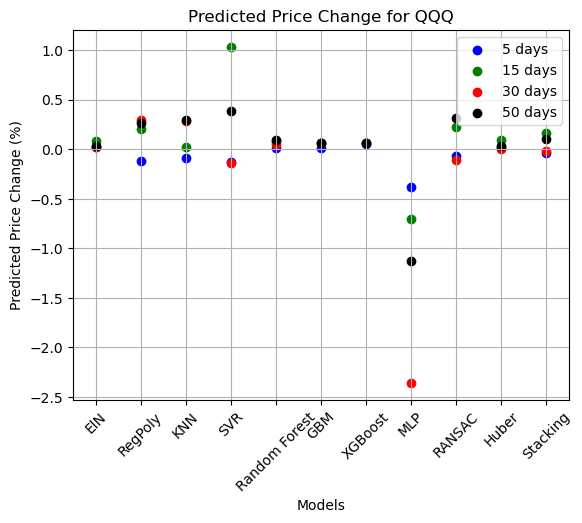

In [21]:
import matplotlib.pyplot as plt

model_names = list(predictions_5_days.keys())
price_changes_5_days = [x * 100 for x in predictions_5_days.values()]
price_changes_15_days = [x * 100 for x in predictions_15_days.values()]
price_changes_30_days = [x * 100 for x in predictions_30_days.values()]
price_changes_50_days = [x * 100 for x in predictions_50_days.values()]

fig, ax = plt.subplots()
ax.scatter(model_names, price_changes_5_days, label="5 days", marker='o', color='blue')
ax.scatter(model_names, price_changes_15_days, label="15 days", marker='o', color='green')
ax.scatter(model_names, price_changes_30_days, label="30 days", marker='o', color='red')
ax.scatter(model_names, price_changes_50_days, label="50 days", marker='o', color='black')

ax.legend()
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Predicted Price Change (%)")
plt.title("Predicted Price Change for QQQ")
plt.grid()
plt.show()

In [3]:
predictions_5_days = predict_stock_direction("SPY", 5, 1000, 'pca', 20, False)
print('=========================================')
predictions_21_days = predict_stock_direction("SPY", 21, 1000, 'pca', 30, False)
print('=========================================')
predictions_60_days = predict_stock_direction("SPY", 60, 1000, 'pca', 40, False)
print('=========================================')

[*********************100%***********************]  1 of 1 completed
Predicted price change for SPY tomorrow:
ElN: 0.06%
RegPoly: 0.03%
KNN: -0.13%
SVR: -0.94%
Random Forest: 0.03%
GBM: 0.04%
XGBoost: 0.04%
MLP: -0.06%
RANSAC: 0.12%
Huber: 0.12%
Stacking: 0.05%

Average predicted price change: -0.06%
Median predicted price change: 0.04%
Min predicted price change: -0.94%
Max predicted price change: 0.12%
[*********************100%***********************]  1 of 1 completed
Predicted price change for SPY tomorrow:
ElN: 0.04%
RegPoly: -0.31%
KNN: 0.05%
SVR: 0.26%
Random Forest: 0.04%
GBM: 0.04%
XGBoost: 0.04%
MLP: -0.56%
RANSAC: 0.17%
Huber: 0.08%
Stacking: 0.08%

Average predicted price change: -0.01%
Median predicted price change: 0.04%
Min predicted price change: -0.56%
Max predicted price change: 0.26%
[*********************100%***********************]  1 of 1 completed
Predicted price change for SPY tomorrow:
ElN: 0.03%
RegPoly: -0.80%
KNN: -0.05%
SVR: 0.20%
Random Forest: 0.05%
GBM: